# Simulation Model Ablation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of AI for Health (AIH), Talavera-López Lab
- **Date of Creation:** 26.06.2024
- **Date of Last Modification:** 03.07.2024

## 1. Setup

- Clone SDMBench from: https://github.com/zhaofangyuan98/SDMBench/tree/main/SDMBench
- Some slight modifications to the SDMBench source code were necessary to remove technical bugs (no functional bugs)

### 1.1 Import Libraries

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import sys
sys.path.append("../../SDMBench/SDMBench")

In [75]:
import os
import random
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)
from SDMBench import sdmbench

### 1.2 Define Parameters

In [3]:
### Dataset ###
n_genes = 1090
n_locs = 10000
increment_mode = "strong"
dataset_name = f"sim_ref_{n_genes}genes_{n_locs}locs_{increment_mode}increments"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 6

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv"
active_gp_thresh_ratio = 0.

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 6
use_cuda_if_available = True

### Analysis ###
cell_type_key = "cell_types"
niche_type_key = "niche_types"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 40
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [4]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [6]:
# Define paths
ga_data_folder_path = "../../datasets/ga_data"
gp_data_folder_path = "../../datasets/gp_data"
st_data_folder_path = "../../datasets/st_data"
st_data_gold_folder_path = st_data_folder_path + "/gold"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../../artifacts"
model_folder_path = f"{artifacts_folder_path}/data_simulation/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/data_simulation/{current_timestamp}/figures"

if n_genes == 1090:
    sim_gps_stats_file_path = "sim_gps_filtered_stats_strongincrements.csv"
elif n_genes == 10854:
    sim_gps_stats_file_path = "sim_gps_stats_strongincrements.csv"

### 1.5 Create Directories

In [7]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(st_data_folder_path, exist_ok=True)

## 2. Prepare Model Training

### 2.1 Create Prior Knowledge Gene Program (GP) Mask

- Here we create a GP mask based on three databases of prior knowledge of inter- and intracellular interaction pathways (equivalent to data simulation):
    - OmniPath (Ligand-Receptor GPs)
    - MEBOCOST (Enzyme-Sensor GPs)
    - NicheNet (Combined Interaction GPs)

In [8]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [9]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [10]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=False)

In [11]:
# Filter and combine GPs
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
combined_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dicts,
    verbose=True)

print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_gp_dict)}.")

Combining ACE2_ligand_receptor_GP and Ace2_ligand_receptor_target_gene_GP.
Combining ACE2_ligand_receptor_GP and L-Phenylalanine_metabolite_enzyme_sensor_GP.
Combining ADCYAP1_ligand_receptor_GP and Adcyap1_ligand_receptor_target_gene_GP.
Combining ADGRE5_ligand_receptor_GP and Adgre5_ligand_receptor_target_gene_GP.
Combining ADIPOQ_ligand_receptor_GP and Adipoq_ligand_receptor_target_gene_GP.
Combining ADM_ligand_receptor_GP and Adm_ligand_receptor_target_gene_GP.
Combining ADM2_ligand_receptor_GP and Adm2_ligand_receptor_target_gene_GP.
Combining AGRP_ligand_receptor_GP and Agrp_ligand_receptor_target_gene_GP.
Combining AGT_ligand_receptor_GP and Agt_ligand_receptor_target_gene_GP.
Combining ALCAM_ligand_receptor_GP and Alcam_ligand_receptor_target_gene_GP.
Combining ALKAL1_ligand_receptor_GP and Alkal1_ligand_receptor_target_gene_GP.
Combining ALKAL2_ligand_receptor_GP and Alkal2_ligand_receptor_target_gene_GP.
Combining AMBN_ligand_receptor_GP and Ambn_ligand_receptor_target_gene_G

In [90]:
# Remove GPs not used in simulation
if n_genes == 1090:
    sim_gps_stats_file_path = "sim_gps_filtered_stats_strongincrements.csv"
elif n_genes == 10854:
    sim_gps_stats_file_path = "sim_gps_stats_strongincrements.csv"

sim_gps_stats = pd.read_csv(f"../../datasets/gp_data/data_simulation/{sim_gps_stats_file_path}")

simulation_gps = set()
for gp in sim_gps_stats["prior_gps"]:
    try:
        simulation_gps.update(gp.split(","))
    except:
        print(f"Skipping {gp}")
for gp in sim_gps_stats["denovo_gps"]:
    try:
        simulation_gps.update(gp.split(","))
    except:
        print(f"Skipping {gp}")

combined_gp_dict_filtered = combined_gp_dict.copy()
for gp in combined_gp_dict.keys():
    if gp not in simulation_gps:
        del(combined_gp_dict_filtered[gp])

Skipping nan
Skipping nan
Skipping nan
Skipping nan
Skipping nan
Skipping nan


### 2.2 Load Data & Compute Spatial Neighbor Graph

In [93]:
# Read data
adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{dataset_name}/{dataset_name}.h5ad")

In [94]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Add GP Mask to Data

In [95]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_gp_dict_filtered,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.4 Explore Data

In [96]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

Number of nodes (observations): 10000
Number of node features (genes): 1090


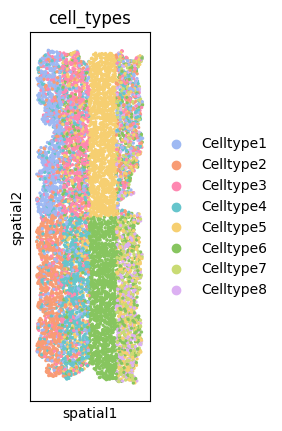

In [97]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=spot_size)        

## 3. Train Model

### 3.1 Initialize, Train & Save Model

In [98]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     n_addon_gp=len(simulation_gps) - len(combined_gp_dict_filtered), # Number of de-novo GPs in simulation
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.0
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1090, n_cat_covariates_embed_input: 0, n_hidden: 315, n_latent: 171, n_addon_latent: 144, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 171, n_addon_gp_input: 144, n_cat_covariates_embed_input: 0, n_output: 1090
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 171, n_addon_gp_input: 144, n_cat_covariates_embed_input: 0, n_output: 1090


In [ ]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 9000
Number of validation nodes: 1000
Number of training edges: 31752
Number of validation edges: 3527
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/400 |--------------------| 0.2% train_global_loss: 1081144.6816; train_optim_loss: 1081144.6816; val_global_loss: 1024725.3438; val_optim_loss: 1024725.3438
Epoch 2/400 |--------------------| 0.5% train_global_loss: 1003853.4961; train_optim_loss: 1003853.4961; val_global_loss: 1000786.5469; val_optim_loss: 1000786.5469
Epoch 3/400 |--------------------| 0.8% train_global_loss: 991226.6836; train_optim_loss: 991226.6836; val_global_loss: 994666.1562; val_optim_loss: 994666.1562
Epoch 4/400 |--------------------| 1.0% train_global_loss: 982929.0996; train_optim_loss: 982929.0996; val_global_loss: 985168.3594; val_optim_loss: 985168.3594
Epoch 5/400 |--------------------| 1.2% train_global_loss: 977856.4492; train_optim_loss: 977856.4492; val_global_loss: 9

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 4. Analysis

In [ ]:
#load_timestamp = "30062024_162615"
load_timestamp = current_timestamp # uncomment if you trained the model in this notebook

figure_folder_path = f"{artifacts_folder_path}/data_simulation/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/data_simulation/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [ ]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

In [ ]:
model.adata.obs[sample_key] = "batch1"

In [ ]:
samples = model.adata.obs[sample_key].unique().tolist()

### 4.1 Visualize NicheCompass Latent GP Space

Let's look at the preservation of cell type annotations in the latent GP space. Note that the goal of NicheCompass is not a separation of cell types but rather to identify spatially consistent cell niches.

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

In [ ]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.2 Identify Niches

We compute Leiden clustering of the NicheCompass latent GP space to identify spatially consistent cell niches.

In [ ]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

In [ ]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.3 Evaluation

### 4.3 Characterize Niches

Now we will characterize the identified cell niches.

#### 4.3.2 Differential GPs

Now we can test which GPs are differentially expressed in a niche. To this end, we will perform differential GP testing of a selected niche, e.g. niche "17" (```selected_cats = ["17"]```) vs all other niches (```comparison_cats = "rest"```). However, differential GP testing can also be performed in the following ways:
- Set ```selected_cats = None``` to perform differential GP testing across all niches, as opposed to just for one specific niche.
- Set ```comparison_cats = ["19"]``` to perform differential GP testing against niche "19" as opposed to against all other niches.

We choose an absolute log bayes factor threshold of 2.3 to determine strongly enriched GPs (see https://en.wikipedia.org/wiki/Bayes_factor).

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

In [ ]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [ ]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key="niche_types",
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

In [ ]:
# Visualize niche types in tissue
sq.pl.spatial_scatter(adata, color="niche_types", shape=None) 

In [ ]:
model.add_active_gp_scores_to_obs()

In [231]:
gp = "Spag11b_ligand_receptor_target_gene_GP"
gp_summary_df[gp_summary_df["gp_name"] == gp]
# Visualize niche types in tissue
sq.pl.spatial_scatter(model.adata, color=gp, shape=None) 
# Visualize niche types in tissue
sq.pl.spatial_scatter(model.adata, color="Spag11b", shape=None) 

In [ ]:
sim_gps_stats = pd.read_csv(f"../../datasets/gp_data/data_simulation/{sim_gps_stats_file_path}")
sim_gps_stats = sim_gps_stats.applymap(lambda x: "" if pd.isna(x) else x)

In [ ]:
# Get all (unique) GPs, target genes and source genes
all_prior_gps = set()
for gp in sim_gps_stats["prior_gps"]:
    if gp != "":
        all_prior_gps.update(gp.split(","))
all_denovo_gps = set()
for gp in sim_gps_stats["denovo_gps"]:
    if gp != "":
        all_denovo_gps.update(gp.split(","))
all_prior_gp_target_genes = set()
for genes in sim_gps_stats["prior_gp_targets"]:
    if genes != "":
        all_prior_gp_target_genes.update(genes.split(","))
all_prior_gp_source_genes = set()
for genes in sim_gps_stats["prior_gp_sources"]:
    if genes != "":
        all_prior_gp_source_genes.update(genes.split(","))
all_denovo_gp_target_genes = set()
for genes in sim_gps_stats["denovo_gp_targets"]:
    if genes != "":
        all_denovo_gp_target_genes.update(genes.split(","))
all_denovo_gp_source_genes = set()
for genes in sim_gps_stats["denovo_gp_sources"]:
    if genes != "":    
        all_denovo_gp_source_genes.update(genes.split(","))

# Compute sign corrected log bayes factor (based on source gene weights)
gp_sign_factors = []
for gp in model.adata.uns[differential_gp_test_results_key]["gene_program"]:
    source_genes_agg_weights = np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]).sum()
    if source_genes_agg_weights > 0:
        gp_sign_factors.append(1)
    else:
        gp_sign_factors.append(-1)

# Filter differential GPs to keep upregulated ones
model.adata.uns[differential_gp_test_results_key]["log_bayes_factor_sign_corrected"] = model.adata.uns[differential_gp_test_results_key]["log_bayes_factor"] * gp_sign_factors 
enriched_gps_filtered = model.adata.uns[differential_gp_test_results_key][model.adata.uns[differential_gp_test_results_key]["log_bayes_factor_sign_corrected"] > 0]

# Get enriched prior gene programs for each niche according to differential gene program test
enriched_prior_gps_per_niche = enriched_gps_filtered.groupby(
    "category")["gene_program"].agg(
    lambda x: set(gp for gp in x if "Add-on" not in gp))

# Get enriched de-novo gene programs for each niche according to differential gene program test
enriched_denovo_gps_per_niche = enriched_gps_filtered.groupby(
    "category")["gene_program"].agg(
    lambda x: set(gp for gp in x if "Add-on" in gp))

In [ ]:
gp_eval_dict = {}
for niche_type in sim_gps_stats["regionA"].unique().tolist():
    if niche_type in enriched_prior_gps_per_niche:
        gp_eval_dict[niche_type] = {"enriched_prior_gps": enriched_prior_gps_per_niche[niche_type]}

        source_genes = []
        target_genes = []
        for gp in enriched_prior_gps_per_niche[niche_type]:
            # Determine gp sign factor
            source_genes_agg_weights = np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]).sum()
            if source_genes_agg_weights > 0:
                gp_sign_factor = 1
            else:
                gp_sign_factor = -1
            
            gp_source_genes_weights =  np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]) * gp_sign_factor
            gp_source_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes"].values[0]
            source_genes.extend(np.array(gp_source_genes)[np.argsort(gp_source_genes_weights)[::-1][:10]].tolist())
        
            gp_target_genes_weights =  np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0]) * gp_sign_factor
            gp_target_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]
            target_genes.extend(np.array(gp_target_genes)[np.argsort(gp_target_genes_weights)[::-1][:10]].tolist())
        
        gp_eval_dict[niche_type]["enriched_prior_gp_source_genes"] = set(source_genes)
        gp_eval_dict[niche_type]["enriched_prior_gp_target_genes"] = set(target_genes)
    else:
        gp_eval_dict[niche_type] = {"enriched_prior_gps": set()}
        gp_eval_dict[niche_type]["enriched_prior_gp_source_genes"] = set()
        gp_eval_dict[niche_type]["enriched_prior_gp_target_genes"] = set()
    if niche_type in enriched_denovo_gps_per_niche:

        source_genes = []
        target_genes = []
        for gp in enriched_denovo_gps_per_niche[niche_type]:
            # Determine gp sign factor
            source_genes_agg_weights = np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]).sum()
            if source_genes_agg_weights > 0:
                gp_sign_factor = 1
            else:
                gp_sign_factor = -1
            
            gp_source_genes_weights =  np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]) * gp_sign_factor
            gp_source_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes"].values[0]
            source_genes.extend(np.array(gp_source_genes)[np.argsort(gp_source_genes_weights)[::-1][:10]].tolist())
        
            gp_target_genes_weights =  np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0]) * gp_sign_factor
            gp_target_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]
            target_genes.extend(np.array(gp_target_genes)[np.argsort(gp_target_genes_weights)[::-1][:10]].tolist())
        
        gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes"] = set(source_genes)
        gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes"] = set(target_genes)
    else:
        gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes"] = set()
        gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes"] = set()
    for increment_param in [3, 5, 8]:
        if len(sim_gps_stats[
        (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gps"]) == 0:
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gps"] = set()
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_source_genes"] = set()
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_target_genes"] = set()
        else:
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gps"] = set(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gps"].apply(
                lambda x: [gp for gp in x.split(",")]).values[0])
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_source_genes"] = set(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gp_sources"].values[0].split(","))
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_target_genes"] = set(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gp_targets"].values[0].split(","))

        if len(sim_gps_stats[
        (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gps"]) == 0:
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gps"] = set()
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_source_genes"] = set()
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_target_genes"] = set()
        else:
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gps"] = set(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gps"].apply(
                lambda x: [gp for gp in x.split(",")]).values[0])
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_source_genes"] = set(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gp_sources"].values[0].split(","))
            gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_target_genes"] = set(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gp_targets"].values[0].split(","))
    gp_eval_dict[niche_type][f"increment_param_1_prior_gps"] = (all_prior_gps -
                                             gp_eval_dict[niche_type][f"increment_param_3_prior_gps"] -
                                             gp_eval_dict[niche_type][f"increment_param_5_prior_gps"] -
                                             gp_eval_dict[niche_type][f"increment_param_8_prior_gps"])
    gp_eval_dict[niche_type][f"increment_param_1_prior_gp_source_genes"] = (all_prior_gp_source_genes -
                                                        gp_eval_dict[niche_type][f"increment_param_3_prior_gp_source_genes"] -
                                                        gp_eval_dict[niche_type][f"increment_param_5_prior_gp_source_genes"] -
                                                        gp_eval_dict[niche_type][f"increment_param_8_prior_gp_source_genes"])
    gp_eval_dict[niche_type][f"increment_param_1_prior_gp_target_genes"] = (all_prior_gp_target_genes -
                                                         gp_eval_dict[niche_type][f"increment_param_3_prior_gp_target_genes"] -
                                                         gp_eval_dict[niche_type][f"increment_param_5_prior_gp_target_genes"] -
                                                         gp_eval_dict[niche_type][f"increment_param_8_prior_gp_target_genes"])
    gp_eval_dict[niche_type][f"increment_param_1_denovo_gps"] = (all_denovo_gps -
                                             gp_eval_dict[niche_type][f"increment_param_3_denovo_gps"] -
                                             gp_eval_dict[niche_type][f"increment_param_5_denovo_gps"] -
                                             gp_eval_dict[niche_type][f"increment_param_8_denovo_gps"])
    gp_eval_dict[niche_type][f"increment_param_1_denovo_gp_source_genes"] = (all_denovo_gp_source_genes -
                                                        gp_eval_dict[niche_type][f"increment_param_3_denovo_gp_source_genes"] -
                                                        gp_eval_dict[niche_type][f"increment_param_5_denovo_gp_source_genes"] -
                                                        gp_eval_dict[niche_type][f"increment_param_8_denovo_gp_source_genes"])
    gp_eval_dict[niche_type][f"increment_param_1_denovo_gp_target_genes"] = (all_denovo_gp_target_genes -
                                                         gp_eval_dict[niche_type][f"increment_param_3_denovo_gp_target_genes"] -
                                                         gp_eval_dict[niche_type][f"increment_param_5_denovo_gp_target_genes"] -
                                                         gp_eval_dict[niche_type][f"increment_param_8_denovo_gp_target_genes"])

gp_eval_df = pd.DataFrame(gp_eval_dict.values(), index=gp_eval_dict.keys())

In [ ]:
n_seeds = 10000

def calculate_intersection(row, col1, col2):
    return len(row[col1].intersection(row[col2]))

def calculate_surplus(row, col1, col2):
    return row[col1] - row[col2]

enriched_surplus_increment_param_dict = {}
random_increment_param_overlap_dict = {}
for seed in range(n_seeds):
    random.seed(seed)
    # Sample random gp from prior knowledge gps so that number matches enriched gps
    gp_eval_df["random_prior_gps"] = gp_eval_df["enriched_prior_gps"].apply(
        lambda x: set(random.sample([gp for gp in all_prior_gps], len(x))))
    
    # Sample random genes from prior knowledge gps so that number matches enriched genes from prior gps
    gp_eval_df["random_prior_gp_target_genes"] = gp_eval_df["enriched_prior_gp_target_genes"].apply(
        lambda x: set(random.sample([gene for gene in all_prior_gp_target_genes], len(x))))
    gp_eval_df["random_prior_gp_source_genes"] = gp_eval_df["enriched_prior_gp_source_genes"].apply(
        lambda x: set(random.sample([gene for gene in all_prior_gp_source_genes], len(x))))
    # Sample random gp from prior knowledge gps so that number matches enriched gps
    gp_eval_df["random_prior_gp_target_genes"] = gp_eval_df["enriched_prior_gp_target_genes"].apply(
        lambda x: set(random.sample([gene for gene in all_prior_gp_target_genes], len(x))))
    gp_eval_df["random_prior_gp_source_genes"] = gp_eval_df["enriched_prior_gp_source_genes"].apply(
        lambda x: set(random.sample([gene for gene in all_prior_gp_source_genes], len(x))))

    # Sample random genes from prior knowledge gps so that number matches enriched genes from prior gps
    gp_eval_df["random_denovo_gp_target_genes"] = gp_eval_df["enriched_denovo_gp_target_genes"].apply(
        lambda x: set(random.sample([gene for gene in all_denovo_gp_target_genes], len(x))))
    gp_eval_df["random_denovo_gp_source_genes"] = gp_eval_df["enriched_denovo_gp_source_genes"].apply(
        lambda x: set(random.sample([gene for gene in all_denovo_gp_source_genes], len(x))))
    
    for increment_param in [1, 3, 5, 8]:
        gp_eval_df[f"enriched_prior_gps_increment_param_{increment_param}_overlap"] = gp_eval_df.apply(lambda row: calculate_intersection(
            row, col1="enriched_prior_gps", col2=f"increment_param_{increment_param}_prior_gps"), axis=1)
        if f"random_prior_gps_increment_param_{increment_param}_overlap" in random_increment_param_overlap_dict.keys():
            random_increment_param_overlap_dict[f"random_prior_gps_increment_param_{increment_param}_overlap"].append(gp_eval_df.apply(lambda row: calculate_intersection(
            row, col1="random_prior_gps", col2=f"increment_param_{increment_param}_prior_gps"), axis=1).values)
        else:
            random_increment_param_overlap_dict[f"random_prior_gps_increment_param_{increment_param}_overlap"] = []

        for gp_gene_type in ["prior_gp_source_genes",
                             "prior_gp_target_genes",
                             "denovo_gp_source_genes",
                             "denovo_gp_target_genes"]:
            gp_eval_df[f"enriched_{gp_gene_type}_increment_param_{increment_param}_overlap"] = gp_eval_df.apply(lambda row: calculate_intersection(
                row, col1=f"enriched_{gp_gene_type}", col2=f"increment_param_{increment_param}_{gp_gene_type}"), axis=1)
            if f"random_{gp_gene_type}_increment_param_{increment_param}_overlap" in random_increment_param_overlap_dict.keys():
                random_increment_param_overlap_dict[f"random_{gp_gene_type}_increment_param_{increment_param}_overlap"].append(gp_eval_df.apply(lambda row: calculate_intersection(
                row, col1=f"random_{gp_gene_type}", col2=f"increment_param_{increment_param}_{gp_gene_type}"), axis=1).values)
            else:
                random_increment_param_overlap_dict[f"random_{gp_gene_type}_increment_param_{increment_param}_overlap"] = []

        if seed == (n_seeds - 1):
            # Compute overlap surplus zscores for enriched gps vs random gps
            gp_eval_df[f"increment_param_{increment_param}_prior_gps_zscore"] = (
                gp_eval_df[f"enriched_prior_gps_increment_param_{increment_param}_overlap"] - np.mean(
                    random_increment_param_overlap_dict[f"random_prior_gps_increment_param_{increment_param}_overlap"], axis=0)) / np.std(
                    random_increment_param_overlap_dict[f"random_prior_gps_increment_param_{increment_param}_overlap"], axis=0) 

            for gp_gene_type in ["prior_gp_source_genes",
                                 "prior_gp_target_genes",
                                 "denovo_gp_source_genes",
                                 "denovo_gp_target_genes"]:
                # Compute overlap surplus zscores for enriched gps vs random gps
                gp_eval_df[f"increment_param_{increment_param}_{gp_gene_type}_zscore"] = (
                    gp_eval_df[f"enriched_{gp_gene_type}_increment_param_{increment_param}_overlap"] - np.mean(
                        random_increment_param_overlap_dict[f"random_{gp_gene_type}_increment_param_{increment_param}_overlap"], axis=0)) / np.std(
                        random_increment_param_overlap_dict[f"random_{gp_gene_type}_increment_param_{increment_param}_overlap"], axis=0) 

In [65]:
gp_eval_df["enriched_denovo_gp_target_genes"]

Region1    {}
Region2    {}
Region3    {}
Region4    {}
Region5    {}
Region6    {}
Region7    {}
Region8    {}
Name: enriched_denovo_gp_target_genes, dtype: object

In [62]:
gp_eval_df[f"increment_param_{increment_param}_denovo_gp_source_genes_zscore"]

Region1   NaN
Region2   NaN
Region3   NaN
Region4   NaN
Region5   NaN
Region6   NaN
Region7   NaN
Region8   NaN
Name: increment_param_8_denovo_gp_source_genes_zscore, dtype: float64

In [ ]:
output_df = pd.DataFrame([[nmi,hom,com,chaos,pas,asw,moranI,gearyC]],
               index = ["NicheCompass"],#your method name
               columns=[['Accuracy','Accuracy','Accuracy','Continuity','Continuity','Continuity','Marker score','Marker score'],
                        ['NMI','HOM','COM','CHAOS','PAS','ASW','Moran\'I','Geary\'s C']])

In [60]:
scores_dict = {}
scores_dict["run_number"] = 1
scores_dict["ari"] = sdmbench.compute_ARI(
    model.adata,
    "niche_types",
    latent_cluster_key)
scores_dict["nmi"] = sdmbench.compute_NMI(
    model.adata,
    "niche_types",
    latent_cluster_key)
scores_dict["chaos"] = sdmbench.compute_CHAOS(
    model.adata,
    latent_cluster_key)
scores_dict["pas"] = sdmbench.compute_PAS(
    model.adata,
    latent_cluster_key,
    spatial_key="spatial")
scores_dict["asw"] = sdmbench.compute_ASW(
    model.adata,
    latent_cluster_key,
    spatial_key="spatial")
scores_dict["hom"] = sdmbench.compute_HOM(
    model.adata,
    "niche_types",
    latent_cluster_key)
scores_dict["com"] = sdmbench.compute_COM(
    model.adata,
    "niche_types",
    latent_cluster_key)
scores_dict["moranI"], scores_dict["gearyC"] = sdmbench.marker_score(
    model.adata,
    "niche_types")


for increment_param in [1, 3, 5, 8]:
    scores_dict[f"increment_param_{increment_param}_prior_gps_zscore"] = np.mean(
        gp_eval_df[f"increment_param_{increment_param}_prior_gps_zscore"])
    scores_dict[f"increment_param_{increment_param}_prior_gp_source_genes_zscore"] = np.mean(
        gp_eval_df[f"increment_param_{increment_param}_prior_gp_source_genes_zscore"])
    scores_dict[f"increment_param_{increment_param}_prior_gp_target_genes_zscore"] = np.mean(
        gp_eval_df[f"increment_param_{increment_param}_prior_gp_target_genes_zscore"])
    scores_dict[f"increment_param_{increment_param}_denovo_gp_source_genes_zscore"] = np.mean(
        gp_eval_df[f"increment_param_{increment_param}_denovo_gp_source_genes_zscore"])
    scores_dict[f"increment_param_{increment_param}_denovo_gp_target_genes_zscore"] = np.mean(
        gp_eval_df[f"increment_param_{increment_param}_denovo_gp_target_genes_zscore"])

In [61]:
scores_dict

{'run_number': 1,
 'increment_param_1_prior_gps_zscore': -3.9204621982325314,
 'increment_param_1_prior_gp_source_genes_zscore': -10.792998029688519,
 'increment_param_1_prior_gp_target_genes_zscore': -5.301750266574835,
 'increment_param_1_denovo_gp_source_genes_zscore': nan,
 'increment_param_1_denovo_gp_target_genes_zscore': nan,
 'increment_param_3_prior_gps_zscore': 1.47449783895276,
 'increment_param_3_prior_gp_source_genes_zscore': 4.159059774496827,
 'increment_param_3_prior_gp_target_genes_zscore': 2.6438940169850733,
 'increment_param_3_denovo_gp_source_genes_zscore': nan,
 'increment_param_3_denovo_gp_target_genes_zscore': nan,
 'increment_param_5_prior_gps_zscore': 2.3157401384994496,
 'increment_param_5_prior_gp_source_genes_zscore': 6.979762364989916,
 'increment_param_5_prior_gp_target_genes_zscore': 2.5187370686104784,
 'increment_param_5_denovo_gp_source_genes_zscore': nan,
 'increment_param_5_denovo_gp_target_genes_zscore': nan,
 'increment_param_8_prior_gps_zscore': 

In [ ]:
sq.pl.spatial_scatter(adata, color="Pck1", shape=None) 

In [ ]:
gp_eval_df[f"enriched_fc_1_overlap"]

In [ ]:
random_fc_overlap_dict[f"random_fc_1_overlap"]

In [ ]:
enriched_prior_gps_per_niche["Region1"].intersection(gp_fc_dict["gp_fc_1"])

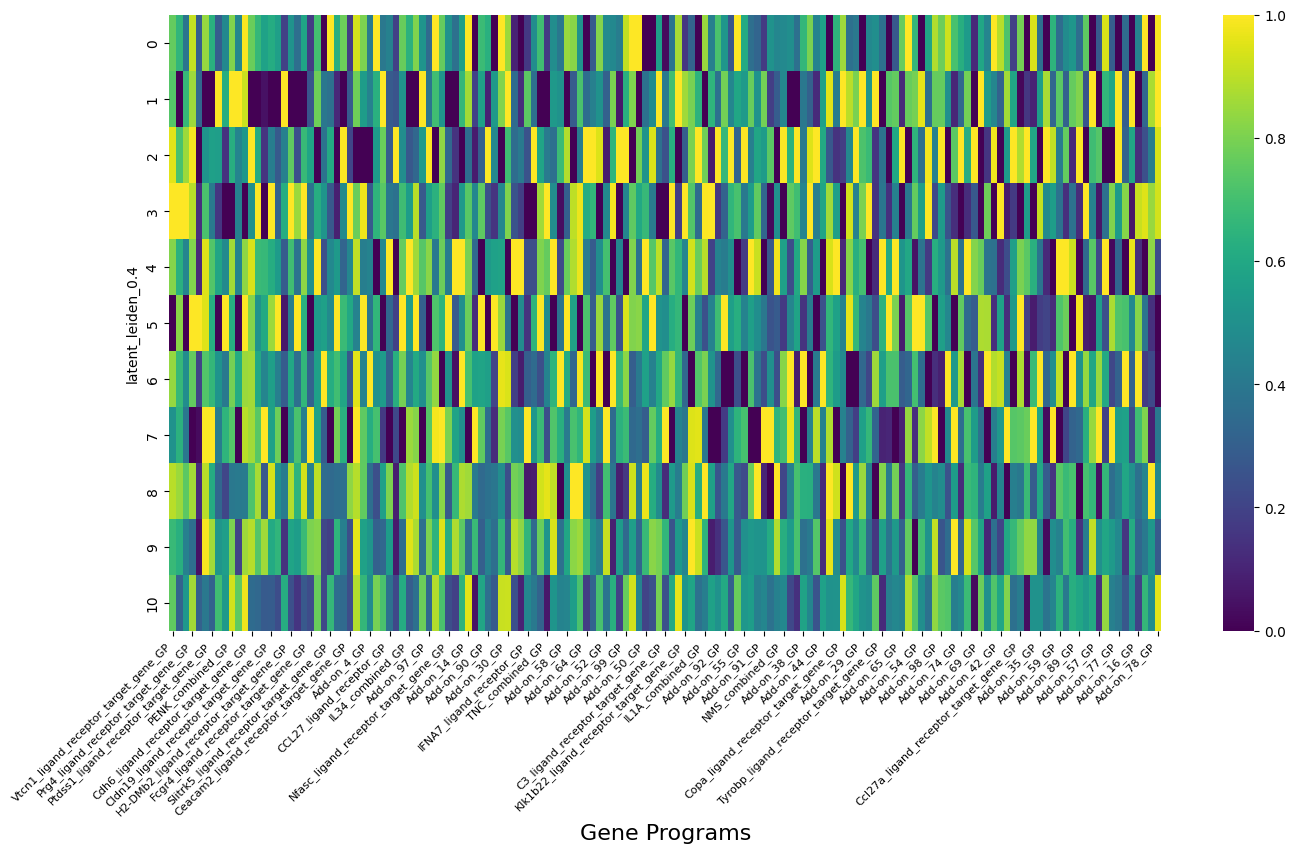

In [92]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [93]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

Now we will have a look at the GP activities and the log normalized counts of
the most important omics features of the differential GPs.

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f149ec94250>>
Traceback (most recent call last):
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f1468f2cc10> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

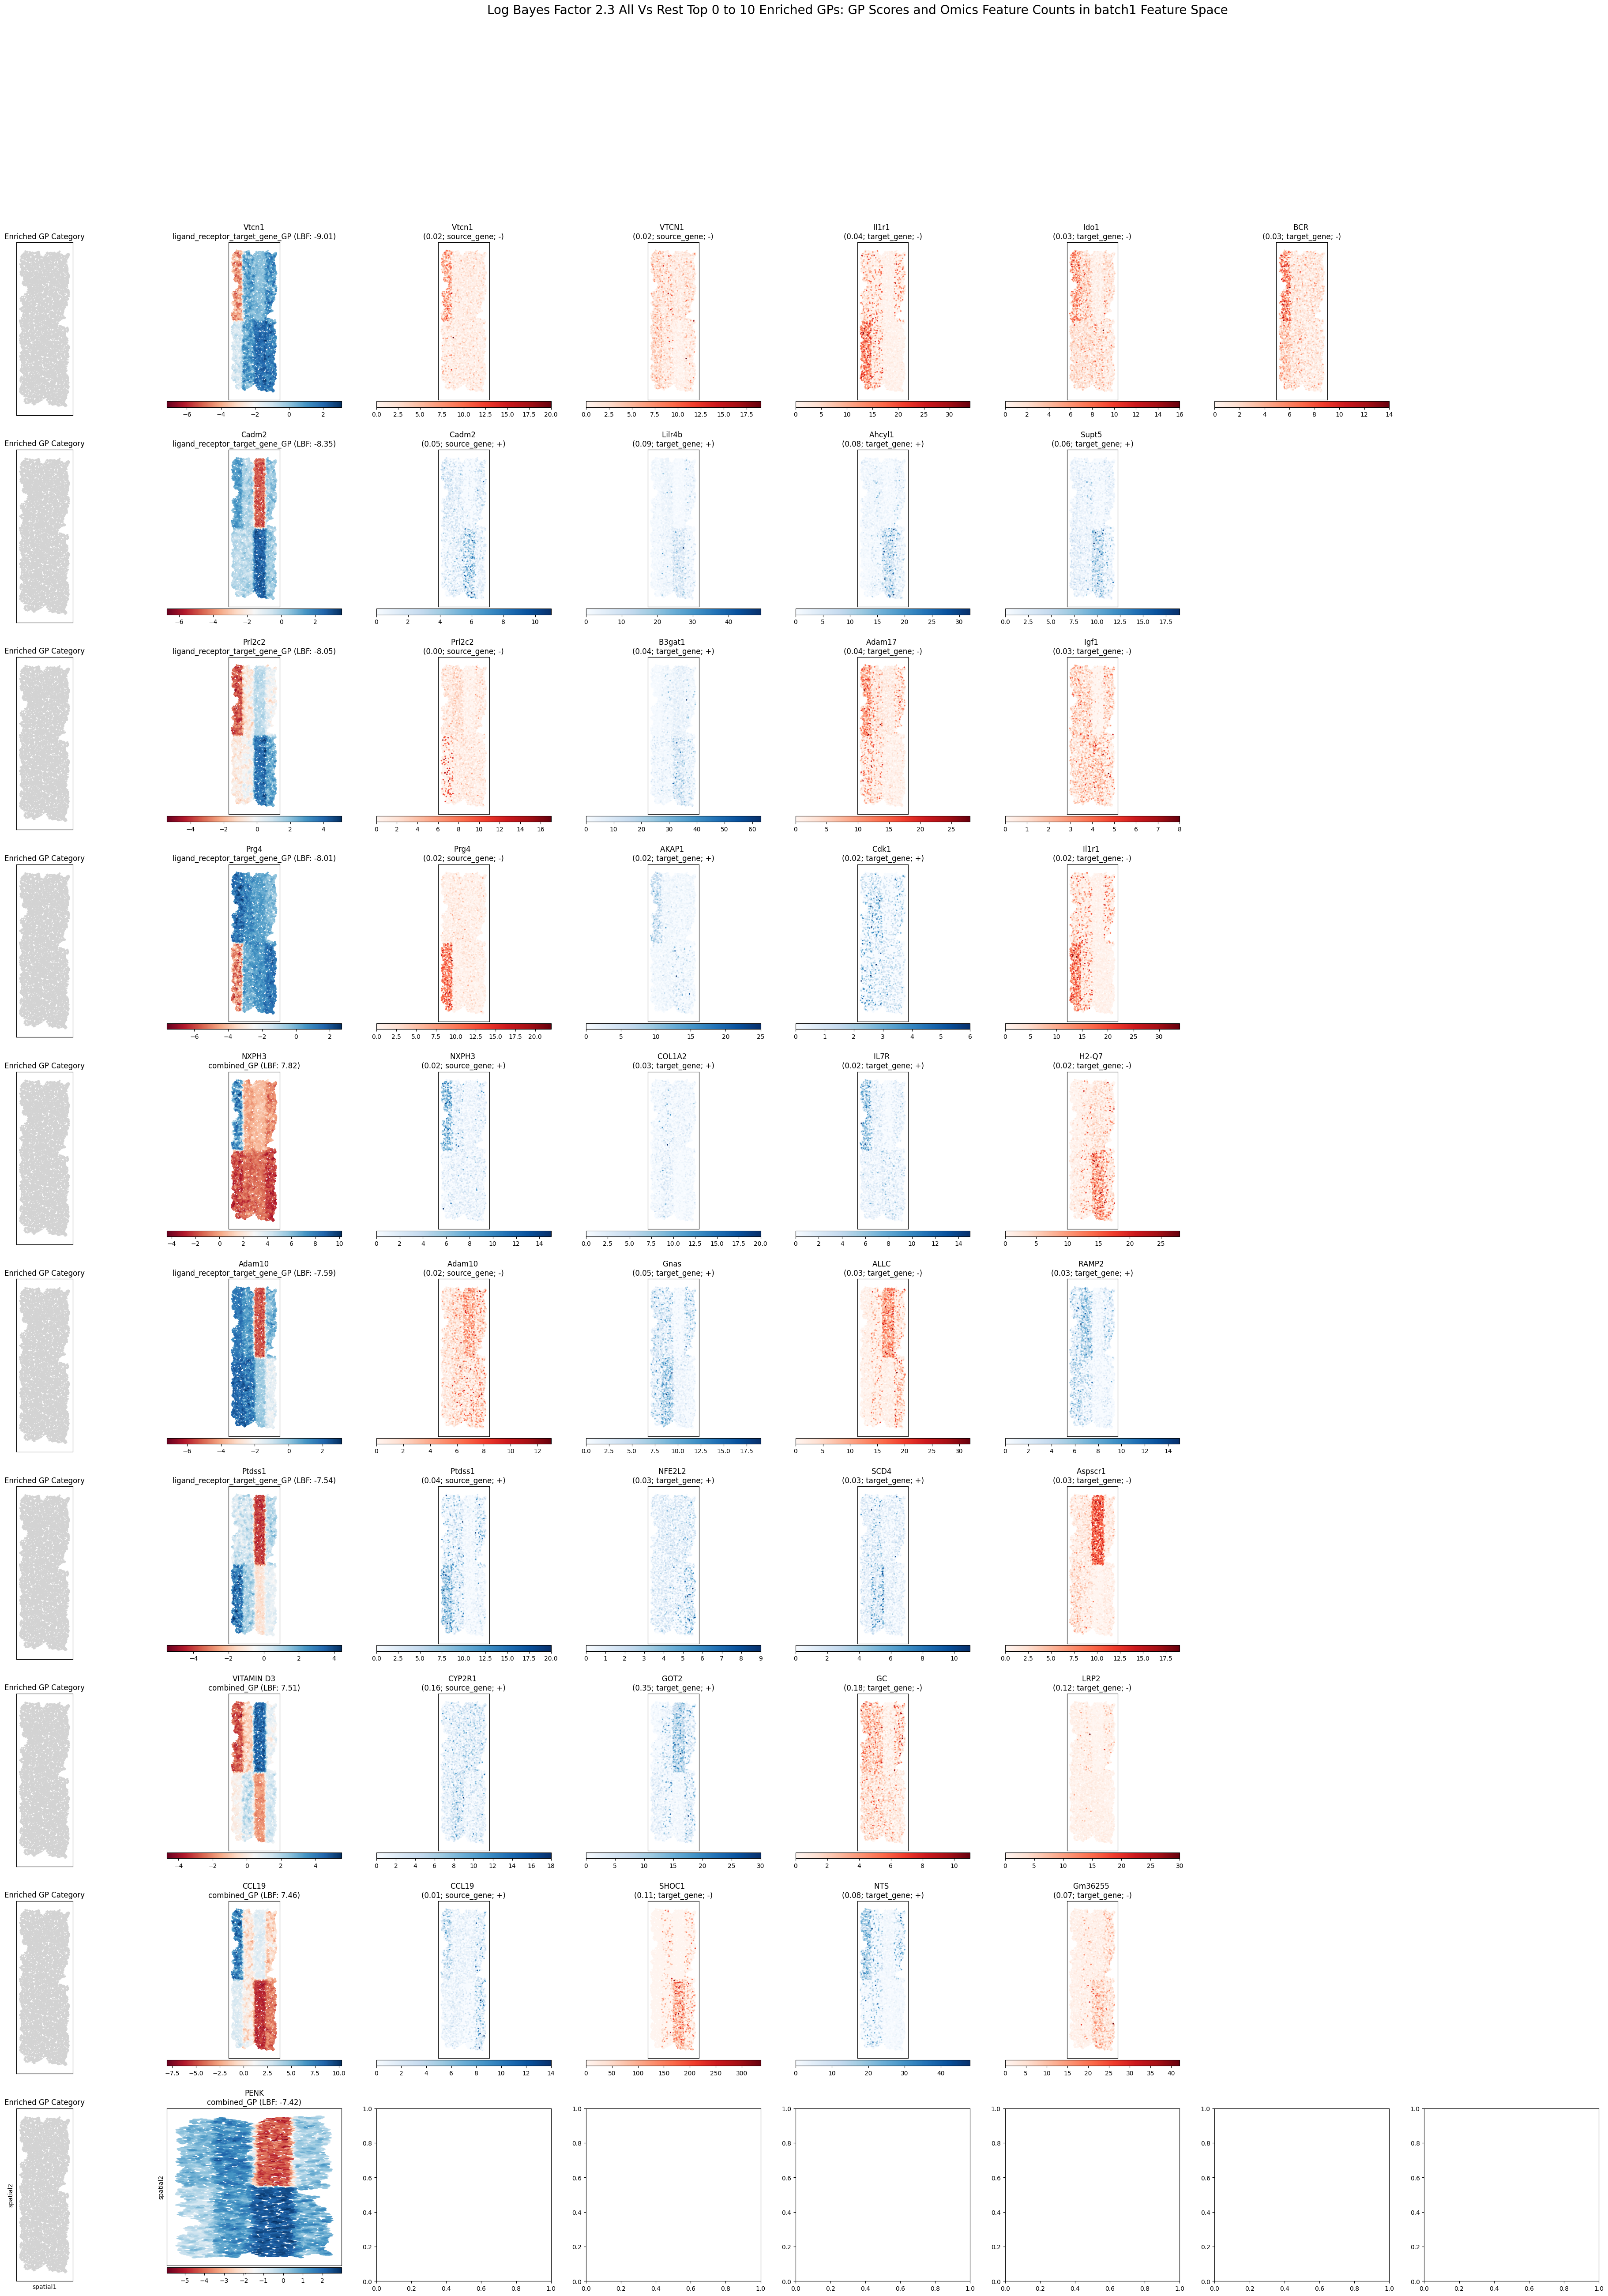

In [94]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_all_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

#### 4.3.3 Cell-cell Communication

Now we will use the inferred activity of an enriched combined interaction GP to analyze the involved intercellular interactions.

In [ ]:
gp_name = "Kl_ligand_receptor_target_gene_GP"

In [ ]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )